In [1]:
using JLD2
using FourierFlows
using FourierFlows: parsevalsum2
using Printf
using CairoMakie
using AbstractFFTs
include("../../utils/IFMAB3.jl")
include("../../rsw/RotatingShallowWater.jl")
include("../../rsw/RSWUtils.jl")
include("AnalysisUtils.jl")
using .RotatingShallowWater

In [2]:
#run_directory = "/vast/nad9961/rsw/59916630/1/"
#run_directory = "/vast/nad9961/rsw/60577145/"
#run_directory = "/vast/nad9961/rsw/60839900/"
#run_directory = "/vast/nad9961/rsw/60979792/"
#run_directory = "/scratch/nad9961/rsw/57478245/1/"
#run_directory = "/vast/nad9961/rsw/61087952/"
#run_directory = "/vast/nad9961/rsw/61126019/"
run_directory = "/vast/nad9961/rsw/61132843/"
Nsnapshots = count_key_snapshots(run_directory, "rsw")

4007

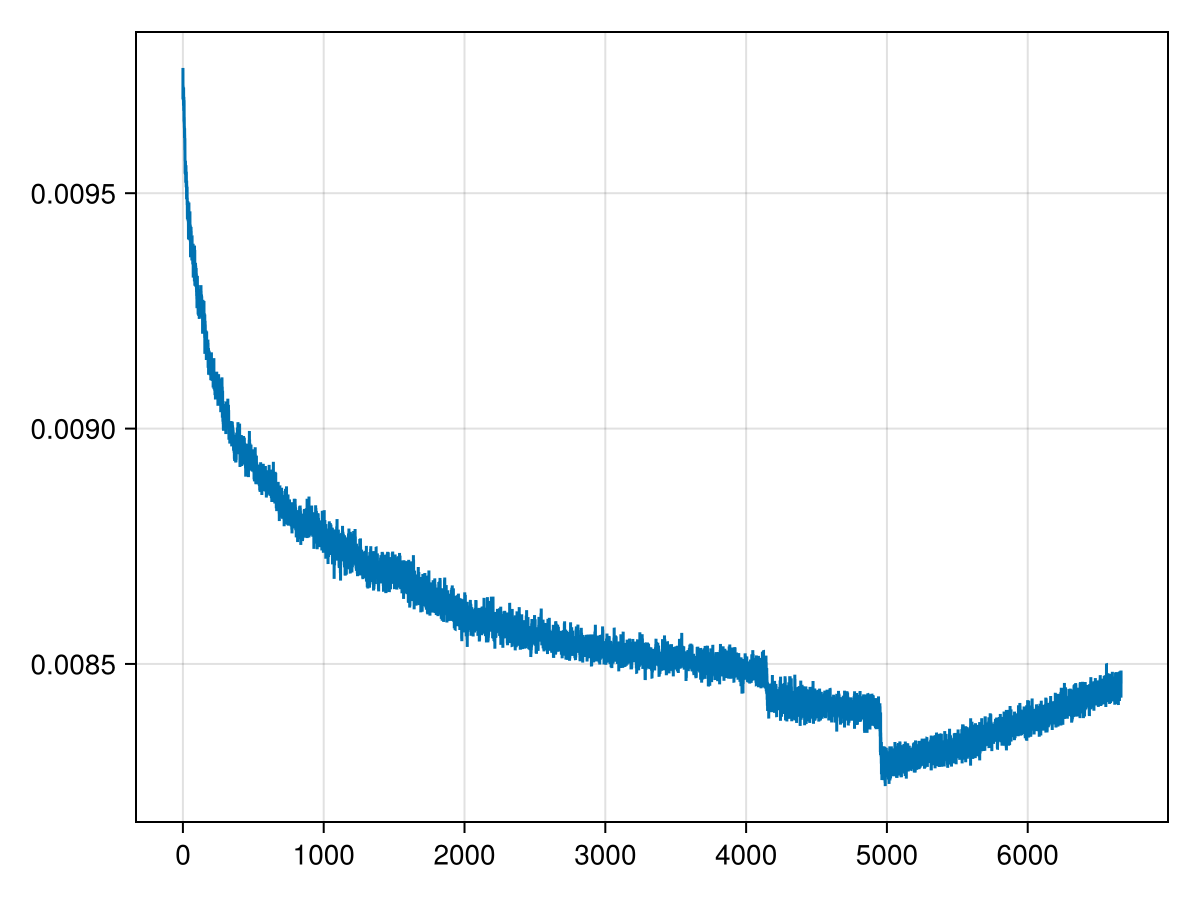

In [7]:
diagnositics = jldopen(run_directory * "diagnostics.jld2")
diag_t = diagnositics["diagnostics/KE/t"]
KE = diagnositics["diagnostics/KE/data"]
PE = diagnositics["diagnostics/PE/data"]
close(diagnositics)

fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, diag_t, KE + 0.5*PE)


fig

In [41]:
t, rsw_sol = load_key_snapshot(run_directory, "rsw", Nsnapshots)

(3519.5327f0, ComplexF32[2.674973f0 + 0.0f0im -28.134771f0 - 486.4068f0im … -327.9362f0 + 252.1115f0im 831.9518f0 - 119.0331f0im; 565.1933f0 - 384.71643f0im 67.206894f0 + 286.00345f0im … -257.6197f0 + 448.43643f0im -439.54013f0 - 26.72541f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; -6.591921f0 + 0.0f0im -470.56824f0 + 423.84787f0im … -147.2672f0 + 121.133766f0im -649.4409f0 - 298.03662f0im; -379.5873f0 - 66.49585f0im 263.6414f0 + 617.946f0im … 131.65067f0 + 241.69415f0im -824.91565f0 - 443.445f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; 140.52422f0 - 108.88208f0im 942.2047f0 + 1751.3625f0im … 399.04895f0 + 625.1772f0im 1144.0676f0 - 1464.683f0im; -76.4829f0 + 1554.4203f0im 999.0798f0 - 275.04825f0im … 999.9853f0 + 367.63913f0im -467.39798f0 + 2022.12f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f

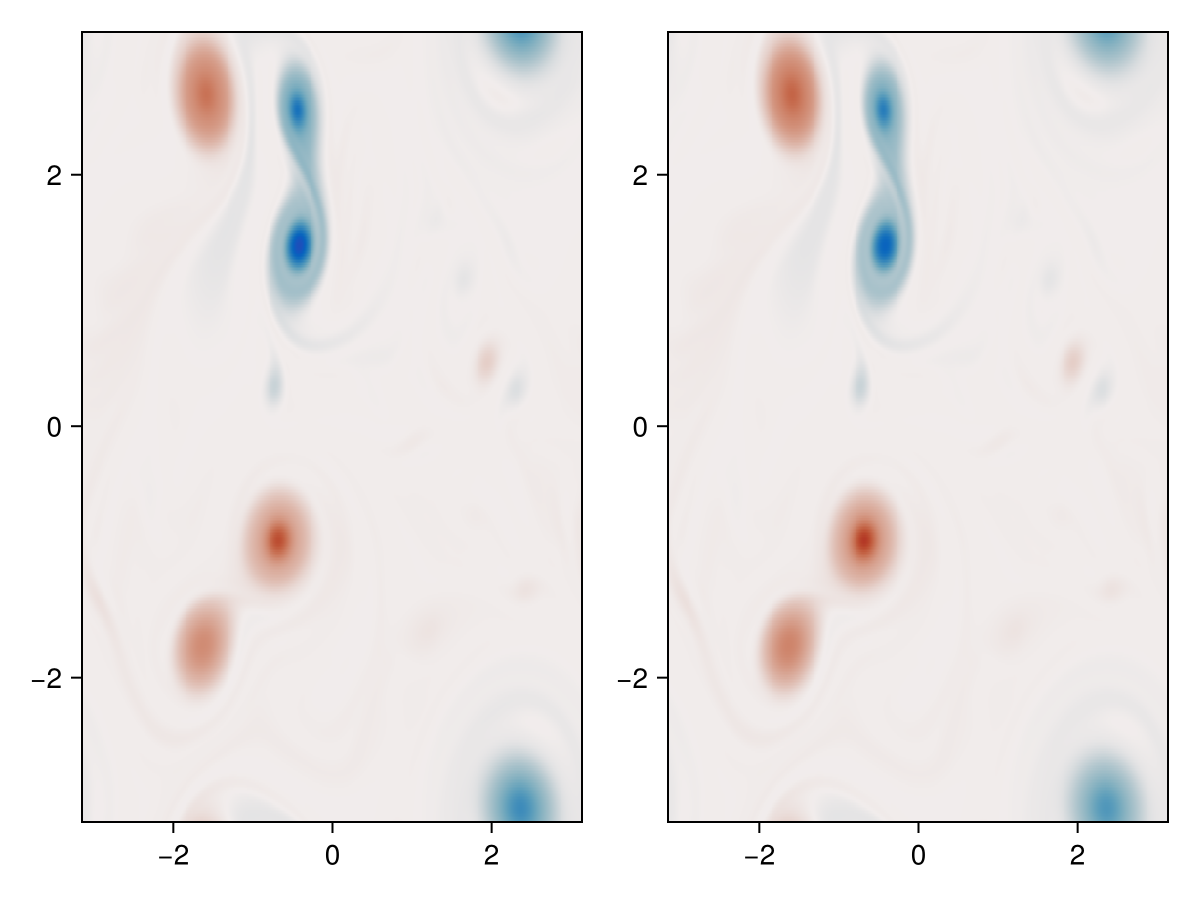

In [42]:
grid = TwoDGrid(; nx=512, Lx=2π)
f0, Cg2 = read_rsw_params(run_directory)
ν, nν = read_rsw_dissipation(run_directory)
uh = rsw_sol[:,:,1]
vh = rsw_sol[:,:,2]
ηh = rsw_sol[:,:,3]

Φ₀, Φ₊, Φ₋ = compute_balanced_wave_bases(grid, (; f=f0, Cg2))
c₀, c₊, c₋ = compute_balanced_wave_weights(uh, vh, ηh, Φ₀, Φ₊, Φ₋)

uxh = @. 1im * grid.kr * uh
vxh = @. 1im * grid.kr * vh
ηxh = @. 1im * grid.kr * ηh
uyh = @. 1im * grid.l  * uh
vyh = @. 1im * grid.l  * vh
ηyh = @. 1im * grid.l  * ηh

u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
η = irfft(ηh, grid.nx)
ux = irfft(uxh, grid.nx)
vx = irfft(vxh, grid.nx)
ηx = irfft(ηxh, grid.nx)
uy = irfft(uyh, grid.nx)
vy = irfft(vyh, grid.nx)
ηy = irfft(ηyh, grid.nx)

uuxh = rfft(u .* ux)
vuyh = rfft(v .* uy)
uvxh = rfft(u .* vx)
vvyh = rfft(v .* vy)
uηxh = rfft(u .* ηx)
vηyh = rfft(v .* ηy)
ηuh  = rfft(η .* u)
ηvh  = rfft(η .* v)
divηuh = @. 1im * grid.kr * ηuh + 1im * grid.l * ηvh

D = -ν * grid.Krsq.^(nν)
dudth = @. (-uuxh - vuyh + D * uh + f0 * vh - Cg2 * ηxh)
dvdth = @. (-uvxh - vvyh + D * vh - f0 * uh - Cg2 * ηyh)
dηdth = @. (-divηuh + D * ηh - uxh - vyh)

Egt = @. conj(c₀) * (dudth * Φ₀[:,:,1] + dvdth * Φ₀[:,:,2] + dηdth * Φ₀[:,:,3])
Ept = @. conj(c₊) * (dudth * Φ₊[:,:,1] + dvdth * Φ₊[:,:,2] + dηdth * Φ₊[:,:,3])
Ent = @. conj(c₋) * (dudth * Φ₋[:,:,1] + dvdth * Φ₋[:,:,2] + dηdth * Φ₋[:,:,3])

ζh = @. 1im * grid.kr * vh - 1im * grid.l * uh
ζ = irfft(ζh, grid.nx)
qh_lin = ζh - f0 * ηh
q_lin = irfft(qh_lin, grid.nx)
q_full = @. (ζ + f0) / ((1 + η)) - f0

fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
heatmap!(ax1, grid.x, grid.y, q_lin, colormap=:balance, colorrange=(-2,2))
heatmap!(ax2, grid.x, grid.y, q_full, colormap=:balance, colorrange=(-2,2))

fig

In [14]:
Nsnapshots = count_key_snapshots(run_directory, "rsw")
println(Nsnapshots)
grid = TwoDGrid(; nx=512, Lx=2π, aliased_fraction=1/2)
f0, Cg2 = read_rsw_params(run_directory)
params = (; f=f0, Cg2)
ν, nν = read_rsw_dissipation(run_directory)

Zh = zeros(grid.nkr, grid.nl)
Eh = zeros(grid.nkr, grid.nl)
prevEh = zeros(grid.nkr, grid.nl)
dEhdt = zeros(grid.nkr, grid.nl)
Egggh = zeros(grid.nkr, grid.nl)
Eggwh = zeros(grid.nkr, grid.nl)
Egwwh = zeros(grid.nkr, grid.nl)
Ewwwh = zeros(grid.nkr, grid.nl)

Egh = zeros(grid.nkr, grid.nl)
Eph = zeros(grid.nkr, grid.nl)
Enh = zeros(grid.nkr, grid.nl)

Dh = zeros(grid.nkr, grid.nl)
Dggh = zeros(grid.nkr, grid.nl)
Dgwh = zeros(grid.nkr, grid.nl)
Dwwh = zeros(grid.nkr, grid.nl)
snap_frames = (Nsnapshots-100):Nsnapshots

E_times = zeros(length(snap_frames))
total_E = zeros(length(snap_frames))
total_Z = zeros(length(snap_frames))
array_idx = 1

Φ₀, Φ₊, Φ₋ = compute_balanced_wave_bases(grid, (; f=f0, Cg2))

_, rsw_sol_old = load_key_snapshot(run_directory, "rsw", snap_frames[1]-1)
uh = rsw_sol_old[:,:,1]
vh = rsw_sol_old[:,:,2]
ηh = rsw_sol_old[:,:,3]
@. prevEh = abs2(uh) + abs2(vh) + Cg2 * abs2(ηh)

for snap_idx = snap_frames
    if (snap_idx % 10 == 0)
        println(snap_idx)
    end
    t, rsw_sol = load_key_snapshot(run_directory, "rsw", snap_idx)
    
    dealias!(rsw_sol, grid)
    
    uh = rsw_sol[:,:,1]
    vh = rsw_sol[:,:,2]
    ηh = rsw_sol[:,:,3]

    ((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(uh, vh, ηh, grid, params)

    c₀, c₊, c₋ = compute_balanced_wave_weights(uh, vh, ηh, Φ₀, Φ₊, Φ₋)

    @. dEhdt += (abs2(uh) + abs2(vh) + Cg2 * abs2(ηh)) - (prevEh)
    
    uxh = @. 1im * grid.kr * uh
    vxh = @. 1im * grid.kr * vh
    ηxh = @. 1im * grid.kr * ηh
    uyh = @. 1im * grid.l  * uh
    vyh = @. 1im * grid.l  * vh
    ηyh = @. 1im * grid.l  * ηh

    ugxh = @. 1im * grid.kr * ugh
    vgxh = @. 1im * grid.kr * vgh
    ηgxh = @. 1im * grid.kr * ηgh
    ugyh = @. 1im * grid.l  * ugh
    vgyh = @. 1im * grid.l  * vgh
    ηgyh = @. 1im * grid.l  * ηgh

    uwxh = @. 1im * grid.kr * uwh
    vwxh = @. 1im * grid.kr * vwh
    ηwxh = @. 1im * grid.kr * ηwh
    uwyh = @. 1im * grid.l  * uwh
    vwyh = @. 1im * grid.l  * vwh
    ηwyh = @. 1im * grid.l  * ηwh
    
    u  = irfft(uh, grid.nx)
    v  = irfft(vh, grid.nx)
    η  = irfft(ηh, grid.nx)
    ux = irfft(uxh, grid.nx)
    vx = irfft(vxh, grid.nx)
    ηx = irfft(ηxh, grid.nx)
    uy = irfft(uyh, grid.nx)
    vy = irfft(vyh, grid.nx)
    ηy = irfft(ηyh, grid.nx)

    ug  = irfft(ugh, grid.nx)
    vg  = irfft(vgh, grid.nx)
    ηg  = irfft(ηgh, grid.nx)
    ugx = irfft(ugxh, grid.nx)
    vgx = irfft(vgxh, grid.nx)
    ηgx = irfft(ηgxh, grid.nx)
    ugy = irfft(ugyh, grid.nx)
    vgy = irfft(vgyh, grid.nx)
    ηgy = irfft(ηgyh, grid.nx)

    uw  = irfft(uwh, grid.nx)
    vw  = irfft(vwh, grid.nx)
    ηw  = irfft(ηwh, grid.nx)
    uwx = irfft(uwxh, grid.nx)
    vwx = irfft(vwxh, grid.nx)
    ηwx = irfft(ηwxh, grid.nx)
    uwy = irfft(uwyh, grid.nx)
    vwy = irfft(vwyh, grid.nx)
    ηwy = irfft(ηwyh, grid.nx)
    
    uuxh = rfft(u .* ux)
    vuyh = rfft(v .* uy)
    uvxh = rfft(u .* vx)
    vvyh = rfft(v .* vy)
    uηxh = rfft(u .* ηx)
    vηyh = rfft(v .* ηy)
    ηuh  = rfft(η .* u)
    ηvh  = rfft(η .* v)

    uuxggh = rfft(ug .* ugx)
    vuyggh = rfft(vg .* ugy)
    uvxggh = rfft(ug .* vgx)
    vvyggh = rfft(vg .* vgy)
    uηxggh = rfft(ug .* ηgx)
    vηyggh = rfft(vg .* ηgy)
    ηuggh  = rfft(ηg .* ug)
    ηvggh  = rfft(ηg .* vg)

    uuxgwh = rfft(ug .* uwx) + rfft(uw .* ugx)
    vuygwh = rfft(vg .* uwy) + rfft(vw .* ugy)
    uvxgwh = rfft(ug .* vwx) + rfft(uw .* vgx)
    vvygwh = rfft(vg .* vwy) + rfft(vw .* vgy)
    uηxgwh = rfft(ug .* ηwx) + rfft(uw .* ηgx)
    vηygwh = rfft(vg .* ηwy) + rfft(vw .* ηgy)
    ηugwh  = rfft(ηg .* uw)  + rfft(ηw .* ug)
    ηvgwh  = rfft(ηg .* vw)  + rfft(ηw .* vg)

    uuxwwh = rfft(uw .* uwx)
    vuywwh = rfft(vw .* uwy)
    uvxwwh = rfft(uw .* vwx)
    vvywwh = rfft(vw .* vwy)
    uηxwwh = rfft(uw .* ηwx)
    vηywwh = rfft(vw .* ηwy)
     ηuwwh = rfft(ηw .* uw)
     ηvwwh = rfft(ηw .* vw)
    
    divηuh   = @. 1im * grid.kr * ηuh   + 1im * grid.l * ηvh
    divηuggh = @. 1im * grid.kr * ηuggh + 1im * grid.l * ηvggh
    divηugwh = @. 1im * grid.kr * ηugwh + 1im * grid.l * ηvgwh
    divηuwwh = @. 1im * grid.kr * ηuwwh + 1im * grid.l * ηvwwh

    E_times[array_idx] = t
    total_E[array_idx] = 0.5 * sum(u.^2 + v.^2) + 0.5 * Cg2 * sum(η.^2)
    array_idx += 1
    
    D = -ν * grid.Krsq.^(nν)

    dudth = @. (-uuxh - vuyh)# + D * uh + f0 * vh - Cg2 * ηxh)
    dvdth = @. (-uvxh - vvyh)# + D * vh - f0 * uh - Cg2 * ηyh)
    dηdth = @. (-divηuh)# + D * ηh - uxh - vyh)

    duggdth = @. (-uuxggh - vuyggh)# + D * uh + f0 * vh - Cg2 * ηxh)
    dvggdth = @. (-uvxggh - vvyggh)# + D * vh - f0 * uh - Cg2 * ηyh)
    dηggdth = @. (-divηuggh)# + D * ηh - uxh - vyh)

    dugwdth = @. (-uuxgwh - vuygwh)# + D * uh + f0 * vh - Cg2 * ηxh)
    dvgwdth = @. (-uvxgwh - vvygwh)# + D * vh - f0 * uh - Cg2 * ηyh)
    dηgwdth = @. (-divηugwh)       # + D * ηh - uxh - vyh)
    
    duwwdth = @. (-uuxwwh - vuywwh)# + D * uh + f0 * vh - Cg2 * ηxh)
    dvwwdth = @. (-uvxwwh - vvywwh)# + D * vh - f0 * uh - Cg2 * ηyh)
    dηwwdth = @. (-divηuwwh)# + D * ηh - uxh - vyh)

    Euh = @. conj(uh) * dudth
    Evh = @. conj(vh) * dvdth
    Eηh = @. conj(ηh) * dηdth

    Eugggh = @. conj(ugh) * duggdth
    Evgggh = @. conj(vgh) * dvggdth
    Eηgggh = @. conj(ηgh) * dηggdth

    Euggwh = @. conj(ugh) * dugwdth + conj(uwh) * duggdth
    Evggwh = @. conj(vgh) * dvgwdth + conj(vwh) * dvggdth
    Eηggwh = @. conj(ηgh) * dηgwdth + conj(ηwh) * dηggdth

    Eugwwh = @. conj(ugh) * duwwdth + conj(uwh) * dugwdth
    Evgwwh = @. conj(vgh) * dvwwdth + conj(vwh) * dvgwdth
    Eηgwwh = @. conj(ηgh) * dηwwdth + conj(ηwh) * dηgwdth

    Euwwwh = @. conj(uwh) * duwwdth
    Evwwwh = @. conj(vwh) * dvwwdth
    Eηwwwh = @. conj(ηwh) * dηwwdth


    Eh  += real(0.5*(Euh + Evh) + 0.5 * Cg2 * Eηh)
    Egggh  += real(0.5*(Eugggh + Evgggh) + 0.5 * Cg2 * Eηgggh)
    Eggwh  += real(0.5*(Euggwh + Evggwh) + 0.5 * Cg2 * Eηggwh)
    Egwwh  += real(0.5*(Eugwwh + Evgwwh) + 0.5 * Cg2 * Eηgwwh)
    Ewwwh  += real(0.5*(Euwwwh + Evwwwh) + 0.5 * Cg2 * Eηwwwh)
    #Zh += @. real(conj(qh_lin) * (1im * grid.kr * dvdth - 1im * grid.l * dudth - f0 * dηdth))
    
    # Egt += real(@. conj(c₀) * (dudth * Φ₀[:,:,1] + dvdth * Φ₀[:,:,2] + dηdth * Φ₀[:,:,3]))
    # Ept += real(@. conj(c₊) * (dudth * Φ₊[:,:,1] + dvdth * Φ₊[:,:,2] + dηdth * Φ₊[:,:,3]))
    # Ent += real(@. conj(c₋) * (dudth * Φ₋[:,:,1] + dvdth * Φ₋[:,:,2] + dηdth * Φ₋[:,:,3]))

    Dh += @. real(D * 0.5 * (abs2(uh) + abs2(vh) +  Cg2 * abs2(ηh)))
    Dggh += @. real(D * 0.5 * (abs2(ugh) + abs2(vgh) +  Cg2 * abs2(ηgh)))
    Dgwh += @. real(D * 0.5 * (conj(ugh) * uwh + conj(vgh) * vwh +  Cg2 * conj(ηgh) * ηwh))
    Dgwh += @. real(D * 0.5 * (conj(uwh) * ugh + conj(vwh) * vgh +  Cg2 * conj(ηwh) * ηgh))
    Dwwh += @. real(D * 0.5 * (abs2(uwh) + abs2(vwh) +  Cg2 * abs2(ηwh)))

    @. rsw_sol_old = rsw_sol
    @. prevEh = abs2(uh) + abs2(vh) + Cg2 * abs2(ηh)
end

4007
3910
3920
3930
3940
3950
3960
3970
3980
3990
4000


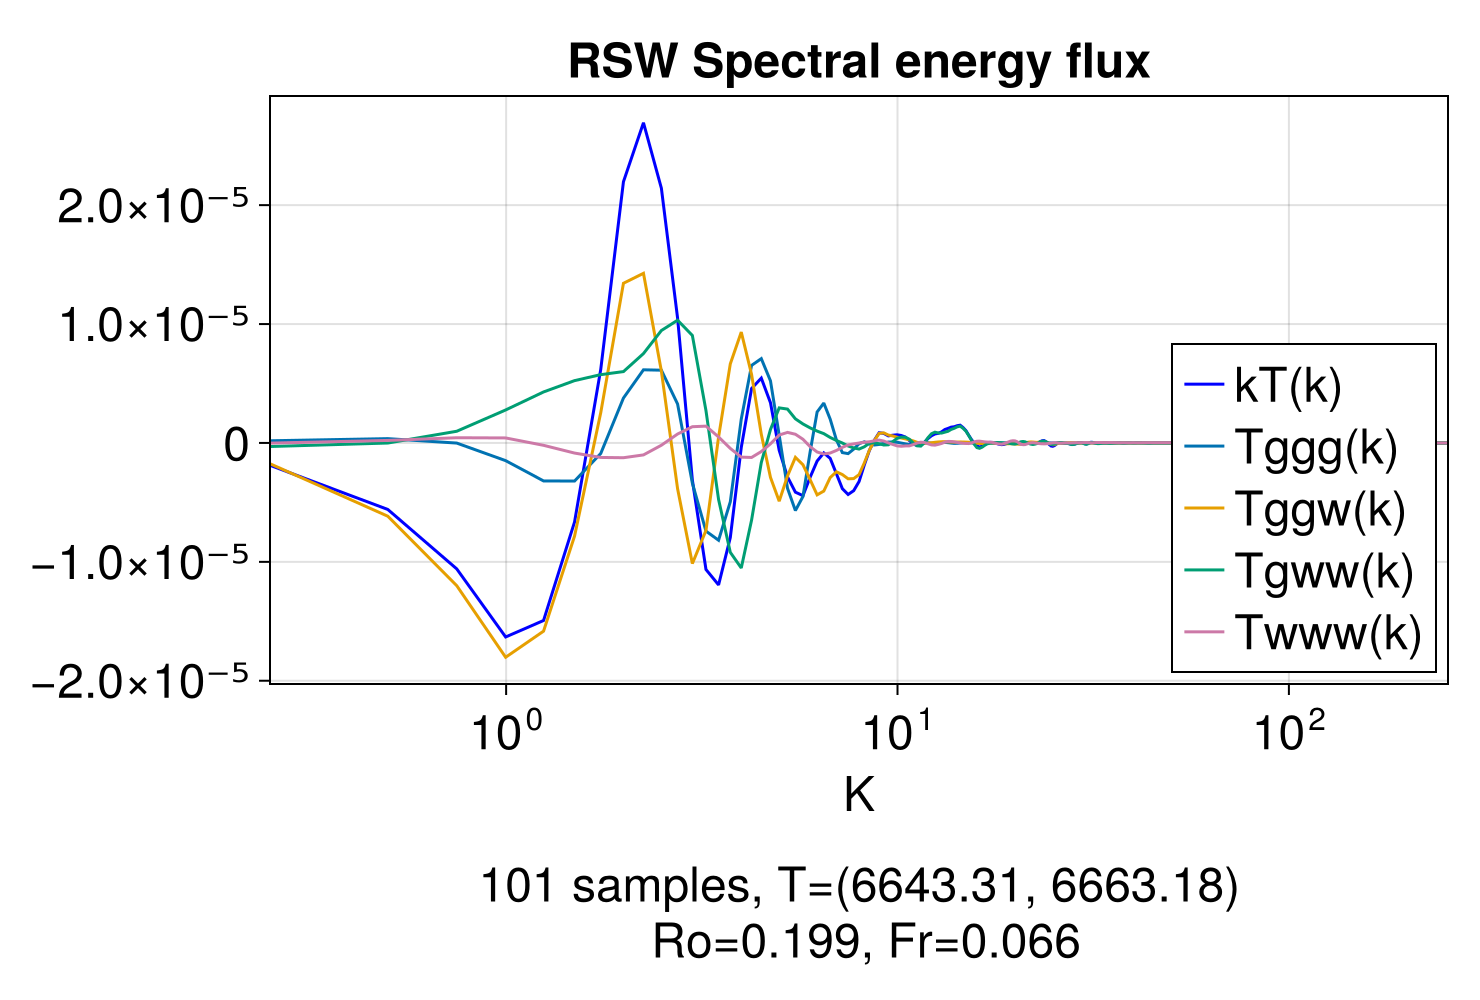

In [17]:
Rh_normed = Eh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
Rgggh_normed = Egggh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
Rggwh_normed = Eggwh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
Rgwwh_normed = Egwwh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
Rwwwh_normed = Ewwwh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
dEhdt_normed = dEhdt * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)

Dggh_normed = Dggh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
Dgwh_normed = Dgwh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
Dwwh_normed = Dwwh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)

ρ, Rhr  = FourierFlows.radialspectrum(Rh_normed/length(snap_frames),  grid)
ρ, Rggghr = FourierFlows.radialspectrum(Rgggh_normed/length(snap_frames), grid)
ρ, Rggwhr = FourierFlows.radialspectrum(Rggwh_normed/length(snap_frames), grid)
ρ, Rgwwhr = FourierFlows.radialspectrum(Rgwwh_normed/length(snap_frames), grid)
ρ, Rwwwhr = FourierFlows.radialspectrum(Rwwwh_normed/length(snap_frames), grid)
ρ, dEhdtr = FourierFlows.radialspectrum(dEhdt_normed/length(snap_frames), grid)


ρ, Dgghr = FourierFlows.radialspectrum(Dggh_normed/length(snap_frames), grid)
ρ, Dgwhr = FourierFlows.radialspectrum(Dgwh_normed/length(snap_frames), grid)
ρ, Dwwhr = FourierFlows.radialspectrum(Dwwh_normed/length(snap_frames), grid)

dρ = ρ[2] - ρ[1]
#Zhr = Zhr[:]
Rhr = Rhr[:]
dEhdtr = dEhdtr[:]
Rggghr = Rggghr[:]
Rggwhr = Rggwhr[:]
Rgwwhr = Rgwwhr[:]
Rwwwhr = Rwwwhr[:]

Dgghr = Dgghr[:]
Dgwhr = Dgwhr[:]
Dwwhr = Dwwhr[:]

Πh = cumsum((dρ .* Rhr)[end:-1:1])[end:-1:1]
Πgggh = cumsum((dρ .* Rggghr)[end:-1:1])[end:-1:1]
Πggwh = cumsum((dρ .* Rggwhr)[end:-1:1])[end:-1:1]
Πgwwh = cumsum((dρ .* Rgwwhr)[end:-1:1])[end:-1:1]
Πwwwh = cumsum((dρ .* Rwwwhr)[end:-1:1])[end:-1:1]
#ΠZh = cumsum((dρ .* Zhr)[end:-1:1])[end:-1:1]
#Πh2 = cumsum((dρ .* (Rghr + Rphr + Rnhr))[end:-1:1])[end:-1:1]

fig = Figure(size=(800, 500), fontsize=24)
ax = Axis(fig[1,1]; title = "RSW Spectral energy flux", xlabel="K",
    xscale=log10, limits=((ρ[2], ρ[end]), (nothing, nothing)))
lines!(ax, ρ, Rhr, color=:blue, label="kT(k)")
#lines!(ax, ρ, ρ .* dEhdtr, color=:red, label="kT(k)")
lines!(ax, ρ, Rggghr, label="Tggg(k)")
lines!(ax, ρ, Rggwhr, label="Tggw(k)")
lines!(ax, ρ, Rgwwhr, label="Tgww(k)")
lines!(ax, ρ, Rwwwhr, label="Twww(k)")
#lines!(ax, ρ, Dgghr, label="Dgg(k)")
#lines!(ax, ρ, Dgwhr, label="Dgw(k)")
#lines!(ax, ρ, Dwwhr, label="Dww(k)")
#lines!(ax, ρ, 0.3*(Rghr + Rphr + Rnhr), color=:blue, linestyle=:dash, label="T'(k)")
#lines!(ax, ρ, Rghr, color=:green, label="Tg(k)")
#lines!(ax, ρ, Rphr, color=:green, linestyle=:dash, label="Tp(k)")
#lines!(ax, ρ, Rnhr, color=:black, linestyle=:dash, label="Tn(k)")
#lines!(ax, ρ, Πh, color=:red, label="Π(k)")
#lines!(ax, ρ, 0.3*Πh2, color=:red, linestyle=:dash, label="Π'(k)")
#lines!(ax, ρ, Πh2, color=:green, label="Π(k)")
#lines!(ax, ρ, Zhr, color=:green, linestyle=:dash, label="Z(k)")
axislegend(ax, position=:rb)

T_start = E_times[1]
T_end = E_times[end]
diagnostics = jldopen(run_directory * "/diagnostics.jld2")
#u_rms = sqrt.(2 * diagnostics["diagnostics/KE/data"][end])
u_rms = 0.06623295f0
close(diagnostics)
Fr = u_rms / sqrt(Cg2)
Ro = u_rms / (sqrt(Cg2) / f0)
Label(fig[2,1], @sprintf("%d samples, T=(%0.2f, %0.2f)\n Ro=%0.3f, Fr=%0.3f", length(E_times), T_start, T_end, Ro, Fr))

colsize!(fig.layout, 1, Aspect(1, 2))
resize_to_layout!(fig)
#axislegend(ax_diss, position=:lb)
fig

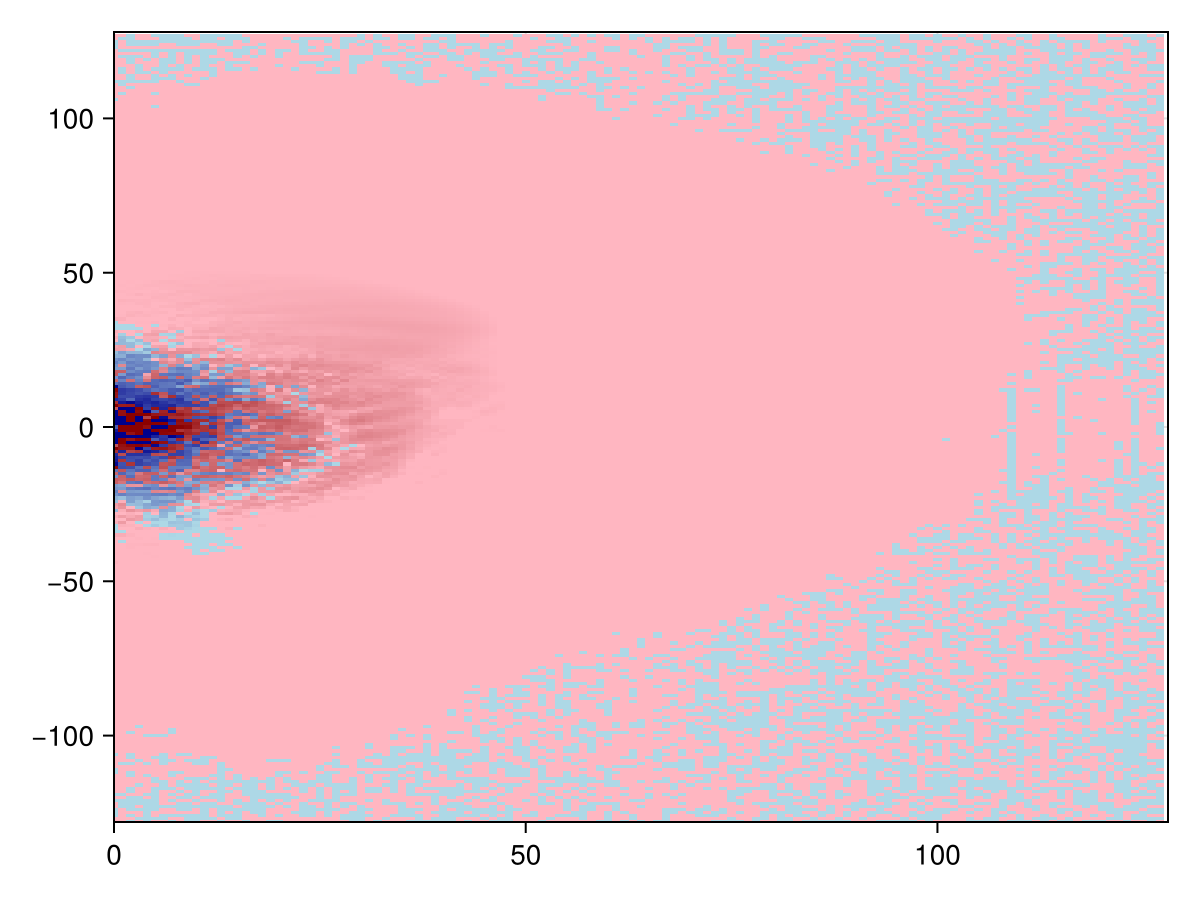

In [46]:
fig = Figure()

α = 1 - grid.aliased_fraction
ax = Axis(fig[1,1], limits=((grid.kr[1], α*grid.kr[end]), (-α*grid.kr[end], α*grid.kr[end])))
pos_Rh = deepcopy(Rh_normed)
neg_Rh = deepcopy(Rh_normed)
pos_Rh[pos_Rh .<= 0.0] .= 0
neg_Rh[neg_Rh .>= 0.0] .= 0 
heatmap!(ax, grid.kr[:], fftshift(grid.l[:]), fftshift(replace(log.( pos_Rh), -Inf=>NaN), 2), colormap=:reds, colorrange=(-23, -11))
heatmap!(ax, grid.kr[:], fftshift(grid.l[:]), fftshift(replace(log.(-neg_Rh), -Inf=>NaN), 2), colormap=:blues, colorrange=(-23, -11))

fig

In [68]:
run_directory = "/vast/nad9961/rsw/61087952"
Nsnapshots = count_key_snapshots(run_directory, "rsw")
println(Nsnapshots)
grid = TwoDGrid(; nx=512, Lx=2π, aliased_fraction=1/2)
f0, Cg2 = read_rsw_params(run_directory)
params = (; f=f0, Cg2)
ν, nν = read_rsw_dissipation(run_directory)

Eh = zeros(Complex{Float64}, grid.nkr, grid.nl)
Eh2 = zeros(Complex{Float64}, grid.nkr, grid.nl)

snap_frames = Nsnapshots:Nsnapshots

for snap_idx = snap_frames
    if (snap_idx % 10 == 0)
        println(snap_idx)
    end
    t, rsw_sol = load_key_snapshot(run_directory, "rsw", snap_idx)
    dealias!(rsw_sol, grid)
    
    uh = rsw_sol[:,:,1]
    vh = rsw_sol[:,:,2]
    ηh = rsw_sol[:,:,3]

    uxh = @. 1im * grid.kr * uh
    vxh = @. 1im * grid.kr * vh
    ηxh = @. 1im * grid.kr * ηh
    uyh = @. 1im * grid.l  * uh
    vyh = @. 1im * grid.l  * vh
    ηyh = @. 1im * grid.l  * ηh

    dk = grid.kr[2] - grid.kr[1]
    for ikx=1:170
        for iky=[1, 2, 3, 512, 511]
            for ipx=1:grid.nkr
                for ipy=1:grid.nl
                    kx = grid.kr[ikx]
                    ky = grid.l[iky]
                    px = grid.kr[ipx]
                    py = grid.l[ipy]
                    qx = kx - px
                    qy = ky - py
                    
                    if qx < 0 || qx > grid.kr[end] || qy < grid.l[grid.nkr] || qy > grid.l[grid.nkr-1]
                        continue
                    end
                    iqx = Int(qx / dk) + 1
                    iqy = Int(qy / dk) + 1
                    if qy < 0
                        iqy += grid.nkr - 1
                    end
                    Eh[ikx, iky] += -conj(uh[ikx, iky]) * (uh[ipx, ipy] * 1im * qx * uh[iqx, iqy])
                    Eh[ikx, iky] += -conj(uh[ikx, iky]) * (uh[iqx, iqy] * 1im * px * uh[ipx, ipy])
                    
                    Eh[ikx, iky] += -conj(uh[ikx, iky]) * (vh[ipx, ipy] * 1im * qy * uh[iqx, iqy])
                    Eh[ikx, iky] += -conj(uh[ikx, iky]) * (vh[iqx, iqy] * 1im * py * uh[ipx, ipy])

                    
                    Eh[ikx, iky] += -conj(vh[ikx, iky]) * (uh[ipx, ipy] * 1im * qx * vh[iqx, iqy])
                    Eh[ikx, iky] += -conj(vh[ikx, iky]) * (uh[iqx, iqy] * 1im * px * vh[ipx, ipy])
                    
                    Eh[ikx, iky] += -conj(vh[ikx, iky]) * (vh[ipx, ipy] * 1im * qy * vh[iqx, iqy])
                    Eh[ikx, iky] += -conj(vh[ikx, iky]) * (vh[iqx, iqy] * 1im * py * vh[ipx, ipy])

                    #Eh[ikx, iky] += -conj(ηh[ikx, iky]) * (1im * px * uh[ipx, ipy] * ηh[iqx, iqy])
                end
            end
        end
    end

    
    u  = irfft(uh, grid.nx)
    v  = irfft(vh, grid.nx)
    η  = irfft(ηh, grid.nx)
    ux = irfft(uxh, grid.nx)
    vx = irfft(vxh, grid.nx)
    ηx = irfft(ηxh, grid.nx)
    uy = irfft(uyh, grid.nx)
    vy = irfft(vyh, grid.nx)
    ηy = irfft(ηyh, grid.nx)
    
    uuxh = rfft(u .* ux)
    vuyh = rfft(v .* uy)
    uvxh = rfft(u .* vx)
    vvyh = rfft(v .* vy)
    uηxh = rfft(u .* ηx)
    vηyh = rfft(v .* ηy)
    ηuh  = rfft(η .* u)
    ηvh  = rfft(η .* v)

    dudth = @. (-uuxh - vuyh)# + D * uh + f0 * vh - Cg2 * ηxh)
    dvdth = @. (-uvxh - vvyh)# + D * vh - f0 * uh - Cg2 * ηyh)
    #dηdth = @. (-divηuh)# + D * ηh - uxh - vyh)
    
    #Eh2 += real(0.5*(Euh + Evh) )#+ 0.5 * Cg2 * Eηh)
end

1006


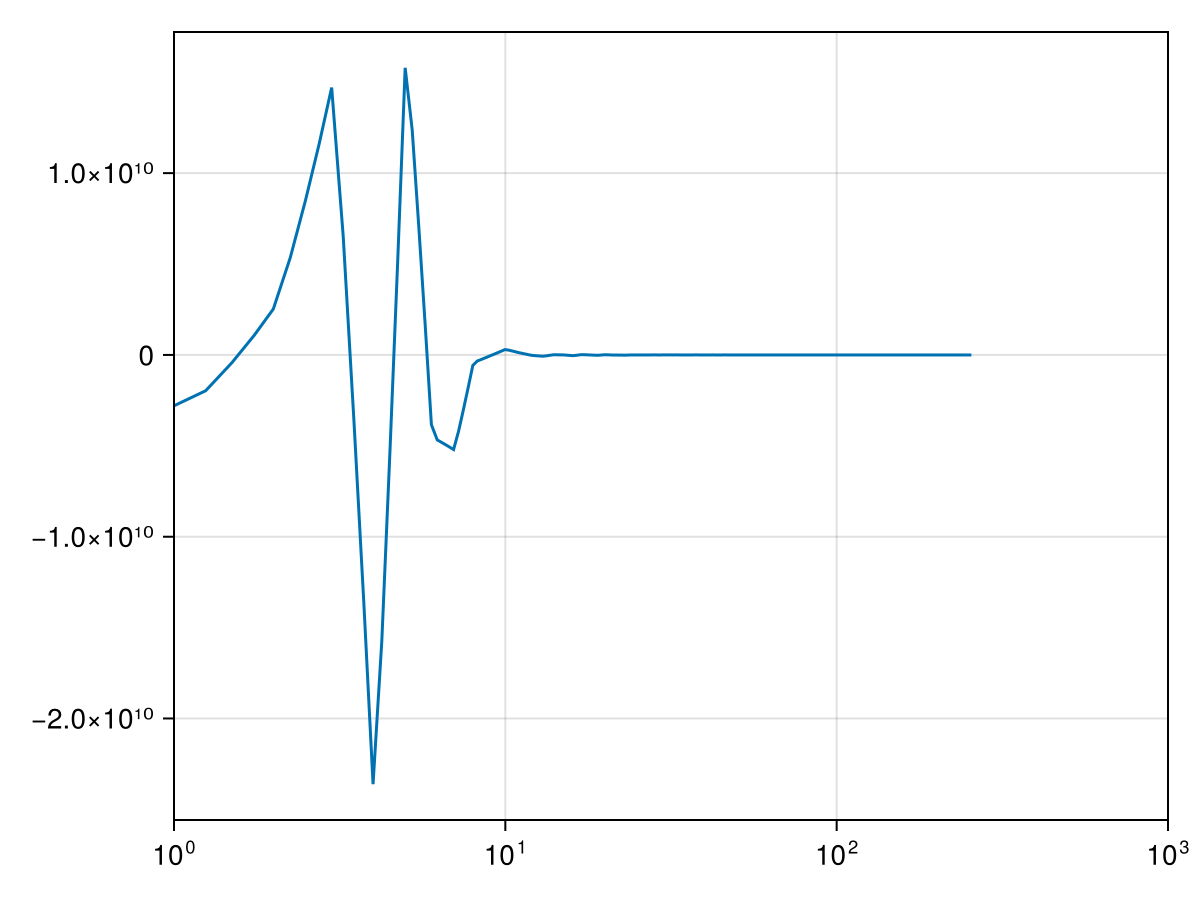

In [65]:
ρ, Ekr = FourierFlows.radialspectrum(real(Eh),  grid)
lines(ρ, Ekr[:]; axis=(;xscale=log10))

7.731113564953368e-7
7.731113564953378e-7
5.3202944914579595e-6
5.443548657815131e-6
0.0014079277651160597
0.23266062861745376


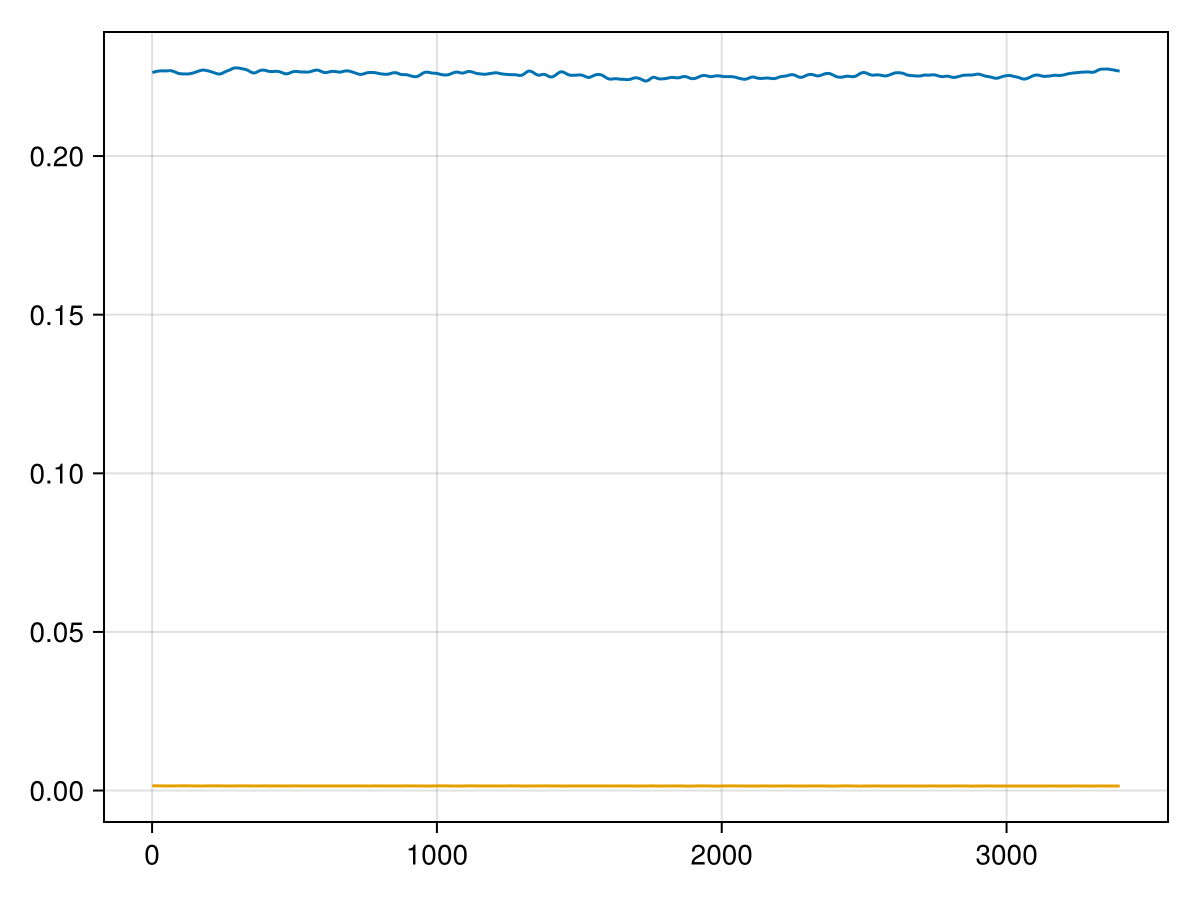

In [48]:
fig = Figure()
ax = Axis(fig[1,1])

dt = (E_times[2] - E_times[1]) * length(E_times)
println(dρ * sum(Rhr))
println(Πh[1])
println((total_E[end] - total_E[1]) / (dt) * grid.dx^2)
println((total_Eh[end] - total_Eh[1]) / (dt))
println(total_Z[end] * grid.dx^2)
println(total_Eh[end])
mean_E = sum(total_E) / length(total_E)
lines!(ax, total_E * grid.dx^2)
lines!(ax, total_Z * grid.dx^2)

fig

In [67]:
grid.l[512]

-1.0

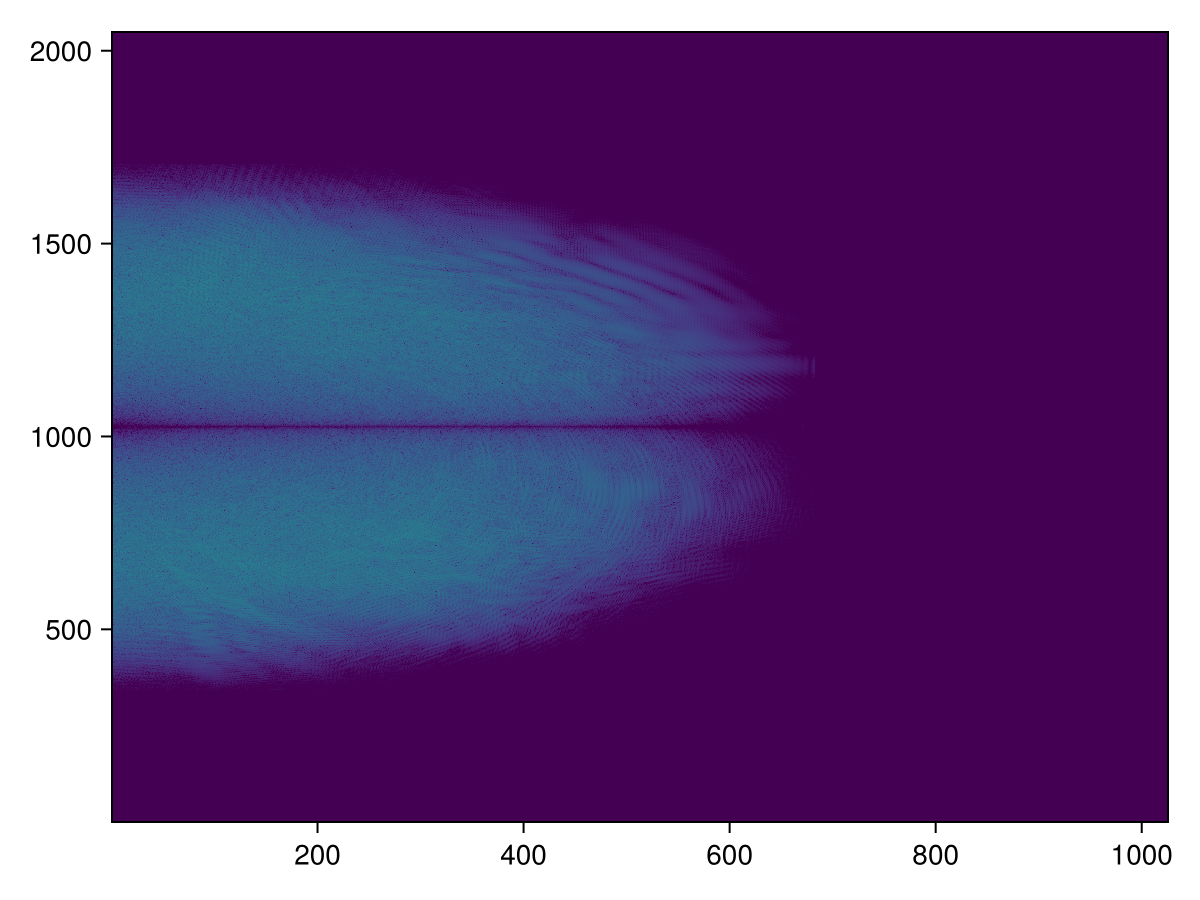

In [10]:
D = -ν * grid.Krsq.^(nν)
heatmap(fftshift(log.(abs.(conj(uh) .* D .* uh)), 2), colorrange=(-20, 15))

In [11]:
t, rsw_sol = load_key_snapshot(run_directory, "rsw", Nsnapshots)
    
uh = rsw_sol[:,:,1]
vh = rsw_sol[:,:,2]
ηh = rsw_sol[:,:,3]

uxh = @. 1im * grid.kr * uh
vxh = @. 1im * grid.kr * vh
ηxh = @. 1im * grid.kr * ηh
uyh = @. 1im * grid.l  * uh
vyh = @. 1im * grid.l  * vh
ηyh = @. 1im * grid.l  * ηh

u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
η = irfft(ηh, grid.nx)
ux = irfft(uxh, grid.nx)
vx = irfft(vxh, grid.nx)
ηx = irfft(ηxh, grid.nx)
uy = irfft(uyh, grid.nx)
vy = irfft(vyh, grid.nx)
ηy = irfft(ηyh, grid.nx)

uuxh = rfft(u .* ux)
vuyh = rfft(v .* uy)
uvxh = rfft(u .* vx)
vvyh = rfft(v .* vy)
uηxh = rfft(u .* ηx)
vηyh = rfft(v .* ηy)
ηuh  = rfft(η .* u)
ηvh  = rfft(η .* v)
divηuh = @. 1im * grid.kr * ηuh + 1im * grid.l * ηvh


D = -ν * grid.Krsq.^(nν)

Euh = @. conj(uh) * (-uuxh - vuyh + D * uh + f0 * vh - Cg2 * ηxh)
Evh = @. conj(vh) * (-uvxh - vvyh + D * vh - f0 * uh - Cg2 * ηyh)
Eηh = @. conj(ηh) * (-divηuh + D * ηh - uxh - vyh)

1025×2048 Matrix{ComplexF64}:
       -0.0+0.0im         4.78851e6-6.42601e7im  …   6.64402e7-8.9972e7im
 -6.22002e7+9.56157e7im   9.58257e5+1.66144e7im      1.22438e8-7.02116e7im
  1.43141e7+5.78292e8im  -3.86372e7-4.21996e7im      3.40946e7+2.71519e7im
 -4.23707e7-6.53367e7im  -3.98012e7+5.94536e7im      1.57845e7+7.69212e7im
 -4.06243e7-6.28276e7im  -8.44888e7-1.78302e8im     -3.99406e7-6.87957e6im
 -2.49528e7+2.81847e7im  -1.62255e7-2.00626e6im  …   3.25552e6-1.08755e6im
 -4.06788e6-7.21555e5im   5.24341e6-6.32698e6im      1.32783e6+2.18114e5im
    82303.4+50951.1im     -515838.0+552093.0im       2.39241e5+96339.4im
 -4.78105e5-5.65594e5im  -6.98301e5-5.17071e5im     -1.14841e6+1.88525e6im
  1.07792e6-9.54755e5im    -20482.2+1.51752e5im      3.81842e5-463975.0im
 -1.14247e5-2.82165e5im   2.42701e5+6.21439e5im  …  -3.16317e5+1.28159e6im
  3.30957e5-2.96443e5im    -11901.7-37600.3im        -4.0248e5-3994.73im
 -1.12707e5-2627.03im      6.3438e5-2.14166e5im       -50225.9-4.12284e5im
 

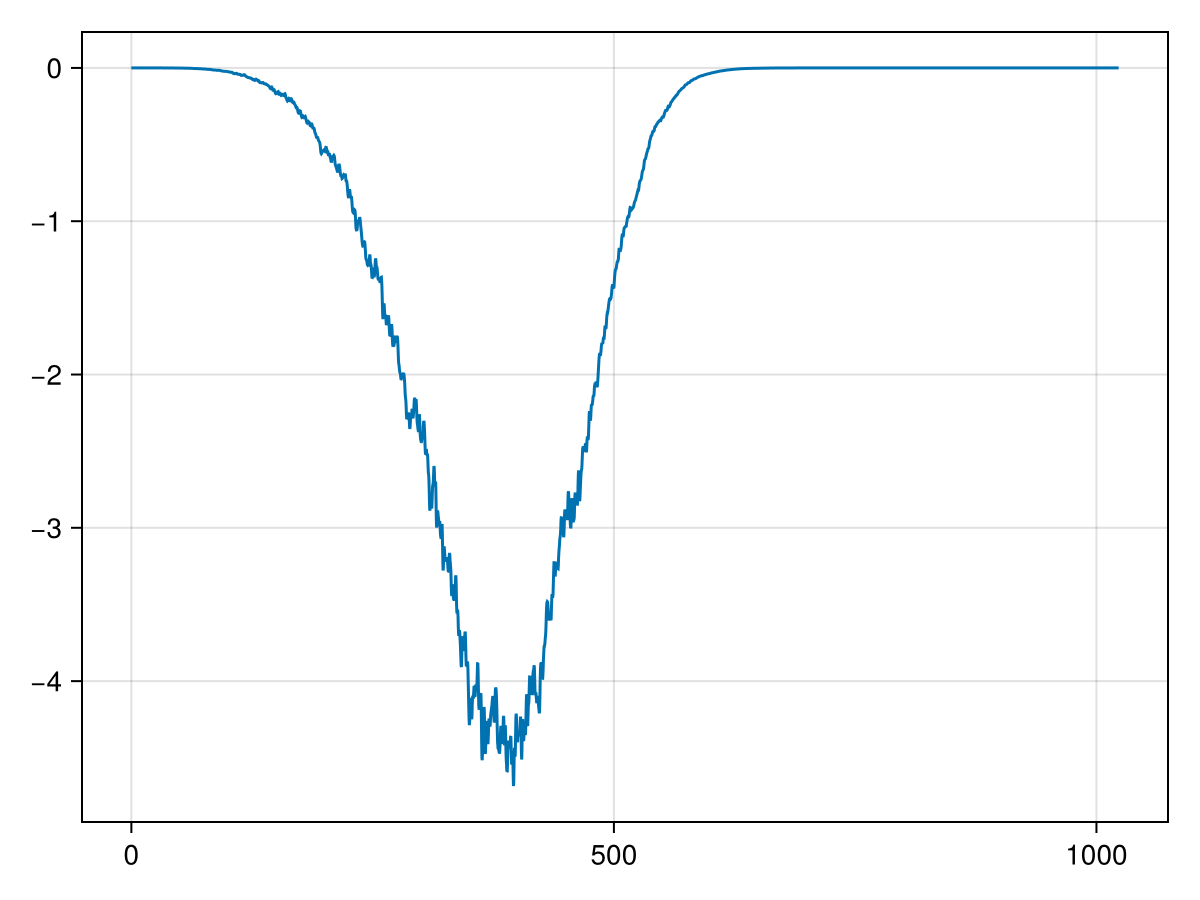

In [12]:
dissipation = D .* (conj(uh) .* uh + conj(vh) .* vh + conj(ηh) .* ηh)
ρ1, Dr = FourierFlows.radialspectrum(dissipation, grid)
lines(ρ1, real(Dr)[:])

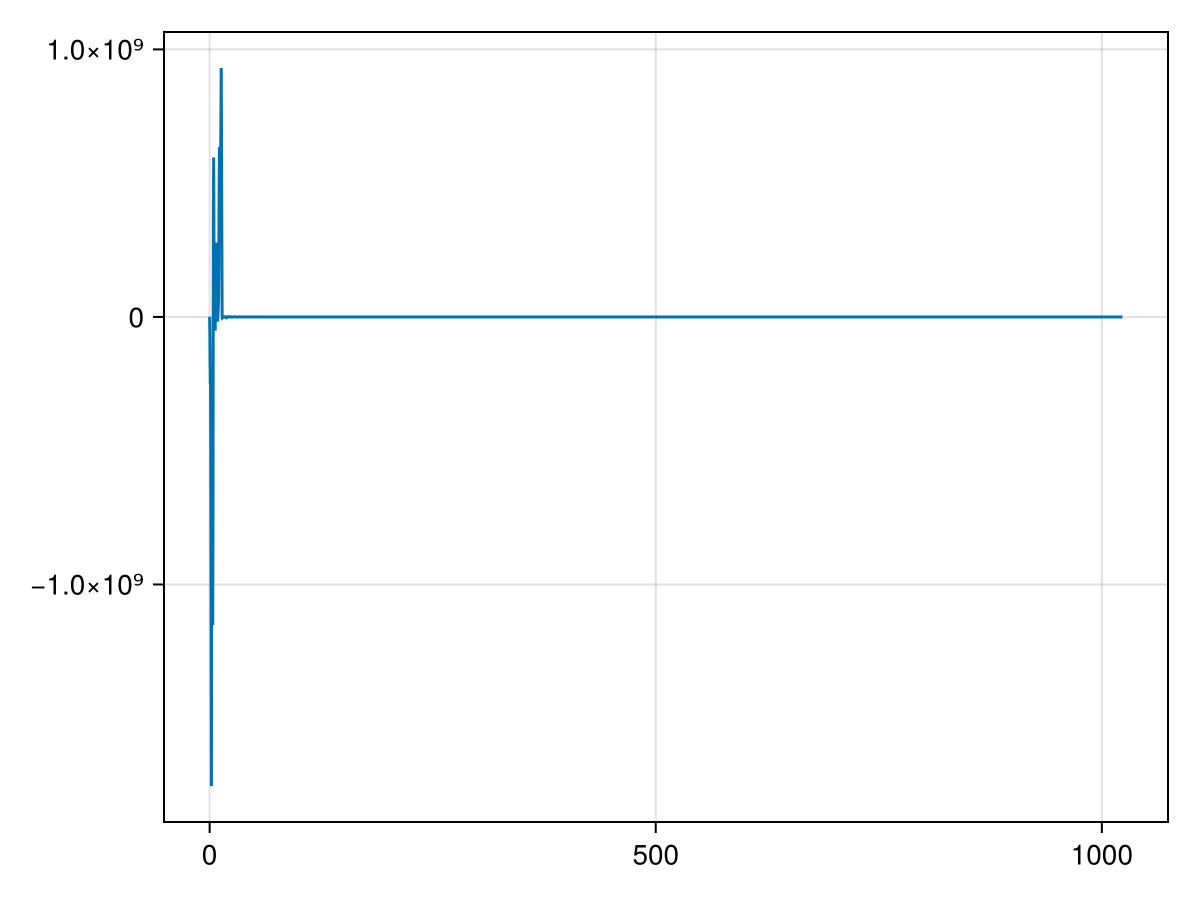

In [13]:
linear_terms = f0 .* (conj(uh) .* uh - conj(vh) .* vh) + Cg2 * conj(ηh) .* (ηxh + ηyh)
ρ1, Lr = FourierFlows.radialspectrum(linear_terms, grid)
lines(ρ1, real(Lr)[:])

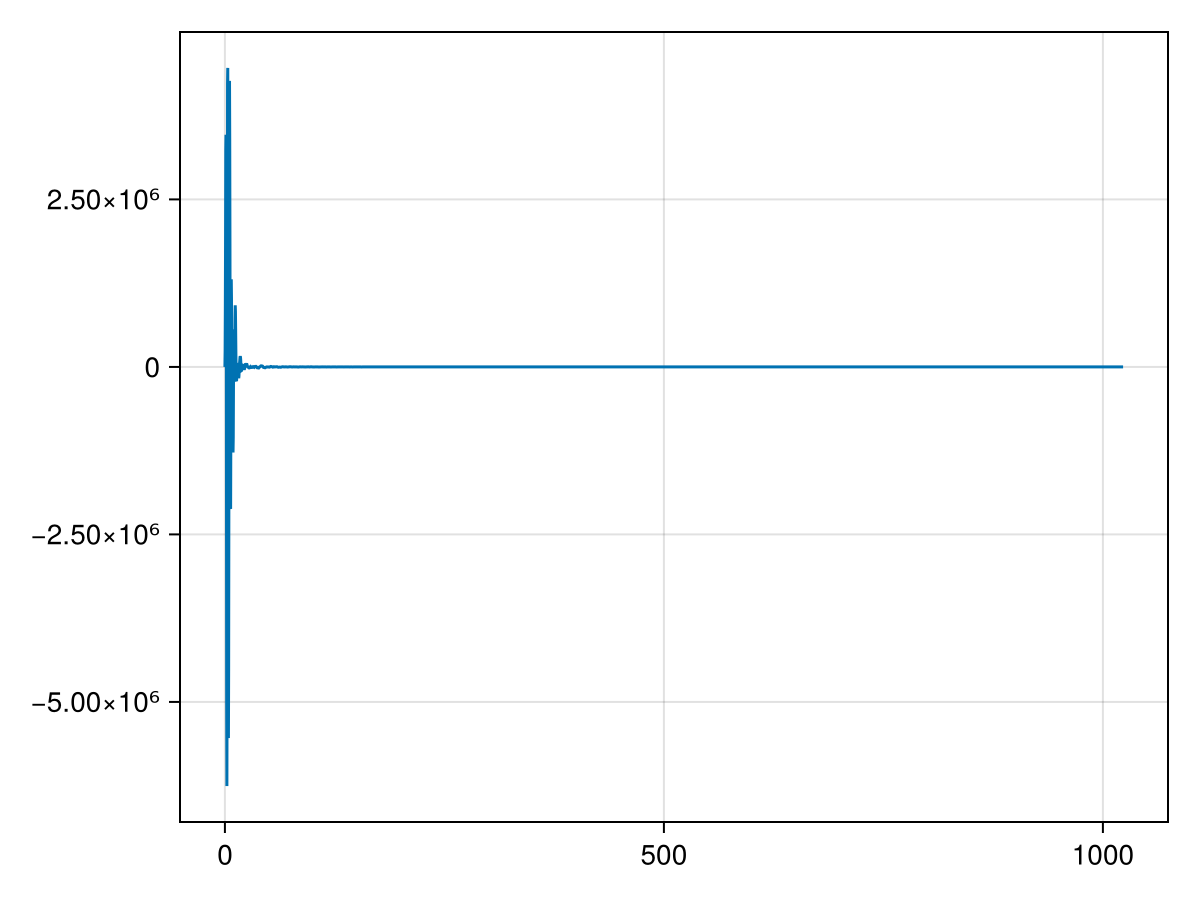

In [14]:
nonlinear_terms = (conj(uh) .* uuxh)
ρ1, Nr = FourierFlows.radialspectrum(nonlinear_terms, grid)
lines(ρ1, real(Nr)[:])